In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
df = pd.read_csv('variables.csv')
df

,Epic_week,Infectious and Parasitic Diseases,Respiratory Infection,Daily_Rainfall_Total_mm,Mean_Temperature_C,Mean_Wind_Speed_kmh
0,2006_01,1306,1437,20.071978,25.928571,7.731429
1,2006_02,1209,1370,33.892308,25.142857,10.257143
2,2006_03,1115,1636,6.319780,26.700000,7.605714
3,2006_04,1083,1785,1.977473,26.930952,13.591429
4,2006_05,1340,2244,0.655495,27.189286,14.111429
...,...,...,...,...,...,...
673,2018_48,1711,2694,8.778947,27.619328,6.638137
674,2018_49,1389,2224,9.319298,27.169853,6.130859
675,2018_50,1621,2712,10.119799,27.022111,6.675198
676,2018_51,1749,2801,4.597494,27.792700,7.526247


In [ ]:
df['Epic_week'] = pd.to_datetime(df['Epic_week'] + '_1', format='%Y_%U_%w')

# set the 'Epic_week_adm' column as the index
df = df.set_index('Epic_week')

# convert the index to week-based format
df.index = df.index.strftime('%Y_%U')

In [ ]:
df

,Infectious and Parasitic Diseases,Respiratory Infection,Daily_Rainfall_Total_mm,Mean_Temperature_C,Mean_Wind_Speed_kmh
Epic_week,,,,,
2006_01,1306,1437,20.071978,25.928571,7.731429
2006_02,1209,1370,33.892308,25.142857,10.257143
2006_03,1115,1636,6.319780,26.700000,7.605714
2006_04,1083,1785,1.977473,26.930952,13.591429
2006_05,1340,2244,0.655495,27.189286,14.111429
...,...,...,...,...,...
2018_48,1711,2694,8.778947,27.619328,6.638137
2018_49,1389,2224,9.319298,27.169853,6.130859
2018_50,1621,2712,10.119799,27.022111,6.675198


In [ ]:
df.shape

(678, 5)

In [ ]:
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)
test_size = len(df) - train_size - val_size
train_set, val_set, test_set = np.split(df, [train_size, train_size+val_size])

# Keep the original index
train_index = train_set.index
val_index = val_set.index
test_index = test_set.index

In [ ]:
scaler = StandardScaler()
scaler.fit(train_set)

train_set = scaler.transform(train_set)
val_set = scaler.transform(val_set)
test_set = scaler.transform(test_set)

In [ ]:
# From np.array back to dataframe
train_set = pd.DataFrame(train_set, columns=df.columns, index=train_index)
val_set = pd.DataFrame(val_set, columns=df.columns, index=val_index)
test_set = pd.DataFrame(test_set, columns=df.columns, index=test_index)

In [ ]:
# create the train, validation, and test datasets
train_tensor = torch.tensor(train_set.values, dtype=torch.float32)
val_tensor = torch.tensor(val_set.values, dtype=torch.float32)
test_tensor = torch.tensor(test_set.values, dtype=torch.float32)

# create new training, validation, and test datasets
train_data = []
for i in range(len(train_tensor)-7):
    train_data.append((train_tensor[i:i+7], train_tensor[i+7, 0]))
inputs, labels = zip(*train_data)
train_dataset = TensorDataset(torch.stack(inputs), torch.tensor(labels))

val_data = []
for i in range(len(val_tensor)-7):
    val_data.append((val_tensor[i:i+7], val_tensor[i+7, 0]))
inputs, labels = zip(*val_data)
val_dataset = TensorDataset(torch.stack(inputs), torch.tensor(labels))

test_data = []
for i in range(len(test_tensor)-7):
    test_data.append((test_tensor[i:i+7], test_tensor[i+7, 0]))
inputs, labels = zip(*test_data)
test_dataset = TensorDataset(torch.stack(inputs), torch.tensor(labels))

# create the train, validation, and test dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
len(train_loader.dataset)

399

In [ ]:
# define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# initialize the model and define the loss and optimizer
input_size = train_tensor.shape[1]
hidden_size = 16
num_layers = 2
model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# train the model
num_epochs = 500
best_val_loss = float('inf')
best_epoch = 0
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # train the model
    train_loss = 0.0
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    
    # evaluate the model on the validation set
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        
    # append the training and validation loss for this epoch
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # print the training and validation loss for each epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, val_loss))
    
    # save the model if the validation loss is the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'lstm_model.pt')

print('The epoch corresponding to the optimal validation loss is {}'.format(best_epoch))

Epoch [1/500], Train Loss: 1.0341, Val Loss: 1.8671
Epoch [2/500], Train Loss: 1.0256, Val Loss: 1.8558
Epoch [3/500], Train Loss: 1.0200, Val Loss: 1.8444
Epoch [4/500], Train Loss: 1.0145, Val Loss: 1.8330
Epoch [5/500], Train Loss: 1.0090, Val Loss: 1.8217
Epoch [6/500], Train Loss: 1.0036, Val Loss: 1.8103
Epoch [7/500], Train Loss: 0.9982, Val Loss: 1.7988
Epoch [8/500], Train Loss: 0.9926, Val Loss: 1.7870
Epoch [9/500], Train Loss: 0.9869, Val Loss: 1.7750
Epoch [10/500], Train Loss: 0.9811, Val Loss: 1.7626
Epoch [11/500], Train Loss: 0.9750, Val Loss: 1.7497
Epoch [12/500], Train Loss: 0.9687, Val Loss: 1.7362
Epoch [13/500], Train Loss: 0.9620, Val Loss: 1.7219
Epoch [14/500], Train Loss: 0.9550, Val Loss: 1.7068
Epoch [15/500], Train Loss: 0.9474, Val Loss: 1.6908
Epoch [16/500], Train Loss: 0.9394, Val Loss: 1.6735
Epoch [17/500], Train Loss: 0.9307, Val Loss: 1.6549
Epoch [18/500], Train Loss: 0.9213, Val Loss: 1.6349
Epoch [19/500], Train Loss: 0.9112, Val Loss: 1.6132
Ep

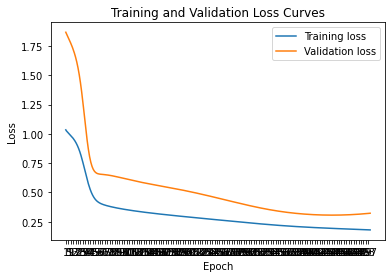

In [ ]:
# plot the training and validation loss curves
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_losses)+1, 4))
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

Test 

In [ ]:
test_set

,Infectious and Parasitic Diseases,Respiratory Infection,Daily_Rainfall_Total_mm,Mean_Temperature_C,Mean_Wind_Speed_kmh
Epic_week,,,,,
2016_20,2.854213,0.118015,0.196785,1.400665,-0.269250
2016_21,2.632892,0.267902,0.057841,2.125467,0.140829
2016_22,1.942581,0.410219,-0.414869,0.920665,-0.644189
2016_23,1.800304,0.149809,-0.095478,1.286607,-0.390481
2016_24,1.547365,-0.063667,0.826997,0.405909,-0.116392
...,...,...,...,...,...
2018_48,2.806787,0.373883,0.214748,0.108537,-0.720772
2018_49,1.109993,-0.337703,0.302265,-0.438129,-0.982807
2018_50,2.332528,0.401135,0.431917,-0.617818,-0.701628


In [ ]:
# evaluate the model on the test set
criterion = nn.MSELoss()
model.load_state_dict(torch.load('lstm_model.pt'))
model.eval()
test_loss = 0.0
outputs_list = []
targets_list = []
with torch.no_grad():
    # a = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item() * inputs.size(0)
        for i in range(len(outputs)):
            outputs_list.append(outputs[i].squeeze())
            targets_list.append(targets[i])
            loss = criterion(outputs[i].squeeze(), targets[i])
            # print('Output {}: Loss: {:.4f}'.format(a, loss))
            # a += 1
    test_loss /= len(test_loader.dataset)
outputs_arr = np.array(outputs_list)
outputs_arr = outputs_arr.reshape(-1,1)
targets_arr = np.array(targets_list)
targets_arr = targets_arr.reshape(-1,1)
print('Test Loss: {:.4f}'.format(test_loss)) 

Test Loss: 0.5579


In [ ]:
outputs_arr_copy = np.repeat(outputs_arr,5, axis=-1)
outputs_arr_copy.shape

(130, 5)

In [ ]:
pred = scaler.inverse_transform(np.reshape(outputs_arr_copy,(len(outputs_arr),5)))[:,0]
pred

array([1589.6868 , 1599.1921 , 1622.1992 , 1624.866  , 1624.7699 ,
       1606.172  , 1653.6189 , 1615.6617 , 1602.2937 , 1639.3868 ,
       1628.0831 , 1649.9215 , 1636.125  , 1635.8154 , 1638.3285 ,
       1643.6718 , 1620.23   , 1622.2098 , 1599.1799 , 1603.9863 ,
       1595.4257 , 1582.5677 , 1574.5303 , 1572.8508 , 1529.5482 ,
       1529.0566 , 1564.109  , 1352.5427 , 1310.7029 , 1369.7821 ,
       1444.2467 , 1512.5088 , 1376.7264 , 1177.1587 , 1111.6144 ,
       1094.3405 , 1038.8019 , 1030.4371 , 1015.34644, 1017.46783,
       1041.7144 , 1044.7644 , 1058.7114 , 1095.4746 , 1090.2836 ,
       1136.4175 , 1100.6621 , 1115.2438 , 1092.3696 , 1076.9379 ,
       1099.0029 , 1023.12366, 1058.8414 , 1054.1143 , 1123.6764 ,
       1220.6377 , 1288.9673 , 1167.4357 , 1113.4003 , 1159.337  ,
       1175.8591 , 1100.9558 , 1134.7211 , 1246.0983 , 1227.6294 ,
       1121.3384 , 1257.9712 , 1277.8142 , 1256.2853 , 1347.665  ,
       1368.9332 , 1340.1364 , 1283.9633 , 1271.5043 , 1199.86

In [ ]:
targets_arr_copy = np.repeat(targets_arr,5, axis=-1)
test_labels = scaler.inverse_transform(np.reshape(targets_arr_copy,(len(targets_arr),5)))[:,0]
test_labels

array([1741., 1700., 1606., 1606., 1647., 1924., 1740., 1704., 1885.,
       1770., 1944., 1803., 1849., 1769., 1976., 1786., 1705., 1631.,
       1653., 1548., 1573., 1595., 1585., 1551., 1517., 1738., 1154.,
       1376., 1393., 1535., 1683., 1324., 1096., 1082., 1095.,  984.,
       1055., 1044., 1039., 1118., 1071., 1082., 1129., 1131., 1218.,
       1161., 1132., 1104., 1150., 1166.,  935., 1128., 1083., 1210.,
       1413., 1474., 1148., 1089., 1197., 1265., 1080., 1222., 1327.,
       1209., 1072., 1349., 1272., 1353., 1439., 1321., 1221., 1212.,
       1263., 1244., 1295., 1407., 1494., 1309., 1350., 1068., 1076.,
       1070.,  890., 1003., 1242., 1215., 1147., 1239., 1301., 1293.,
       1385., 1283., 1237., 1141., 1141., 1263., 1191., 1231., 1087.,
       1236., 1248., 1359., 1297., 1090., 1355., 1345., 1442., 1306.,
       1420., 1549., 1373., 1411., 1310., 1269., 1347., 1475., 1513.,
       1565., 1425., 1464., 1573., 1478., 1566., 1527., 1539., 1711.,
       1389., 1621.,

In [ ]:
def mape(actual, predicted):
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

mape_value = mape(test_labels, pred)
print("MAPE: {:.2f}%".format(mape_value))

MAPE: 8.00%


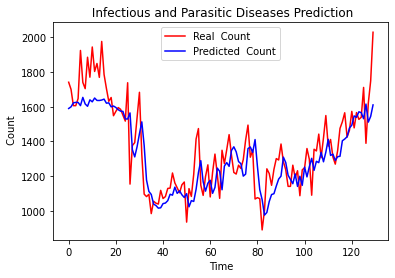

In [ ]:
plt.plot(test_labels, color = 'red', label = 'Real  Count')
plt.plot(pred, color = 'blue', label = 'Predicted  Count')
plt.title(' Infectious and Parasitic Diseases Prediction')
plt.xlabel('Time')
plt.ylabel(' Count')
plt.legend()
plt.show()

检验

In [ ]:
print(inputs)

tensor([[[ 0.8781, -0.2817, -0.8801,  1.0713,  0.5900],
         [ 1.3893, -0.3226, -0.2801,  1.2482,  0.6777],
         [ 0.6726, -0.6632, -0.8851,  1.7203,  0.5276],
         [ 1.2733, -0.9161, -0.7325,  0.3733,  0.2201],
         [ 1.9531, -0.5618, -1.0152,  1.0478,  0.7110],
         [ 1.0257, -0.8343, -1.0350,  2.0989,  1.3482],
         [ 1.2259, -0.8373, -0.0722,  0.9993,  0.4750]],

        [[ 1.3893, -0.3226, -0.2801,  1.2482,  0.6777],
         [ 0.6726, -0.6632, -0.8851,  1.7203,  0.5276],
         [ 1.2733, -0.9161, -0.7325,  0.3733,  0.2201],
         [ 1.9531, -0.5618, -1.0152,  1.0478,  0.7110],
         [ 1.0257, -0.8343, -1.0350,  2.0989,  1.3482],
         [ 1.2259, -0.8373, -0.0722,  0.9993,  0.4750],
         [ 0.6937, -1.2915, -0.7065,  1.0245,  0.1714]],

        [[ 0.6726, -0.6632, -0.8851,  1.7203,  0.5276],
         [ 1.2733, -0.9161, -0.7325,  0.3733,  0.2201],
         [ 1.9531, -0.5618, -1.0152,  1.0478,  0.7110],
         [ 1.0257, -0.8343, -1.0350,  2.0989

In [ ]:
print(outputs)

tensor([[1.2645],
        [1.1775],
        [1.1090],
        [0.9961],
        [1.1253],
        [1.1845],
        [1.3016],
        [1.5434],
        [1.6655],
        [1.9801],
        [2.0727],
        [2.2025],
        [2.1331],
        [2.0382],
        [2.2737],
        [2.1639]])


In [ ]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# test_set

# Multiple Output Strategy (multi_step: 3)
#### prediction(t+1), prediction(t+2) = model(obs(t-1), obs(t-2), ..., obs(t-n))

In [ ]:
# create the train, validation, and test datasets
train_tensor = torch.tensor(train_set.values, dtype=torch.float32)
val_tensor = torch.tensor(val_set.values, dtype=torch.float32)
test_tensor = torch.tensor(test_set.values, dtype=torch.float32)

# create new training, validation, and test datasets
train_data = []
for i in range(0, (len(train_tensor)-9), 3):
    train_data.append((train_tensor[i:i+7], train_tensor[i+7:i+10, 0]))
inputs, labels = zip(*train_data)
train_dataset = TensorDataset(torch.stack(inputs), torch.stack(labels))

val_data = []
for i in range(0, (len(val_tensor)-9), 3):
    val_data.append((val_tensor[i:i+7], val_tensor[i+7:i+10, 0]))
inputs, labels = zip(*val_data)
val_dataset = TensorDataset(torch.stack(inputs), torch.stack(labels))

test_data = []
for i in range(0, (len(test_tensor)-9), 3):
    test_data.append((test_tensor[i:i+7], test_tensor[i+7:i+10, 0]))
inputs, labels = zip(*test_data)
test_dataset = TensorDataset(torch.stack(inputs), torch.stack(labels))

# create the train, validation, and test dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
# define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 3)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# initialize the model and define the loss and optimizer
input_size = train_tensor.shape[1]
hidden_size = 16
num_layers = 2
model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# train the model
num_epochs = 500
best_val_loss = float('inf')
best_epoch = 0
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # train the model
    train_loss = 0.0
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    
    # evaluate the model on the validation set
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        
    # append the training and validation loss for this epoch
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # print the training and validation loss for each epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, val_loss))
    
    # save the model if the validation loss is the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'lstm_model.pt')

print('The epoch corresponding to the optimal validation loss is {}'.format(best_epoch))

Epoch [1/500], Train Loss: 0.9023, Val Loss: 0.9189
Epoch [2/500], Train Loss: 0.9005, Val Loss: 0.9181
Epoch [3/500], Train Loss: 0.8993, Val Loss: 0.9170
Epoch [4/500], Train Loss: 0.8982, Val Loss: 0.9158
Epoch [5/500], Train Loss: 0.8971, Val Loss: 0.9147
Epoch [6/500], Train Loss: 0.8961, Val Loss: 0.9135
Epoch [7/500], Train Loss: 0.8950, Val Loss: 0.9123
Epoch [8/500], Train Loss: 0.8939, Val Loss: 0.9111
Epoch [9/500], Train Loss: 0.8929, Val Loss: 0.9099
Epoch [10/500], Train Loss: 0.8918, Val Loss: 0.9086
Epoch [11/500], Train Loss: 0.8907, Val Loss: 0.9074
Epoch [12/500], Train Loss: 0.8896, Val Loss: 0.9062
Epoch [13/500], Train Loss: 0.8885, Val Loss: 0.9050
Epoch [14/500], Train Loss: 0.8874, Val Loss: 0.9038
Epoch [15/500], Train Loss: 0.8863, Val Loss: 0.9025
Epoch [16/500], Train Loss: 0.8851, Val Loss: 0.9013
Epoch [17/500], Train Loss: 0.8840, Val Loss: 0.9000
Epoch [18/500], Train Loss: 0.8828, Val Loss: 0.8987
Epoch [19/500], Train Loss: 0.8816, Val Loss: 0.8974
Ep

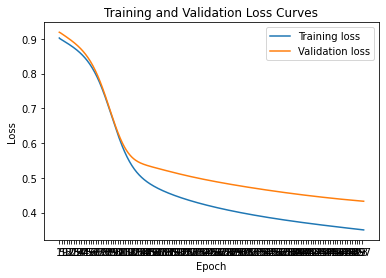

In [ ]:
# plot the training and validation loss curves
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_losses)+1, 4))
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

Test

In [ ]:
# evaluate the model on the test set
model = LSTMModel(input_size, hidden_size, num_layers)
model.load_state_dict(torch.load('lstm_model.pt'))
model.eval()
test_loss = 0.0
outputs_list = []
targets_list = []
with torch.no_grad():
    # a = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item() * inputs.size(0)
        for i in range(len(outputs)):
            for j in range(len(outputs[i])):
              outputs_list.append(outputs[i][j].squeeze())
              targets_list.append(targets[i][j])
              loss = criterion(outputs[i][j].squeeze(), targets[i][j])
              # print('Output {}: Loss: {:.4f}'.format(a, loss))
              # a += 1
    test_loss /= len(test_loader.dataset)
outputs_arr = np.array(outputs_list)
outputs_arr = outputs_arr.reshape(-1,1)
targets_arr = np.array(targets_list)
targets_arr = targets_arr.reshape(-1,1)
print('Test Loss: {:.4f}'.format(test_loss)) 

Test Loss: 0.7568


In [ ]:
outputs_arr_copy = np.repeat(outputs_arr,5, axis=-1)
outputs_arr_copy.shape

(96, 5)

In [ ]:
pred = scaler.inverse_transform(np.reshape(outputs_arr_copy,(len(outputs_arr),5)))[:,0]
pred

array([1508.3417 , 1456.8182 , 1541.8826 , 1512.599  , 1456.5254 ,
       1547.0431 , 1527.8726 , 1468.847  , 1574.0354 , 1520.3958 ,
       1463.4017 , 1565.3739 , 1529.798  , 1469.9901 , 1577.7726 ,
       1527.8276 , 1469.363  , 1577.08   , 1525.2563 , 1466.8824 ,
       1568.7582 , 1520.9679 , 1464.5525 , 1555.4061 , 1490.8424 ,
       1444.2028 , 1515.9265 , 1461.0673 , 1427.2188 , 1477.3748 ,
       1389.9717 , 1362.3331 , 1350.3546 , 1323.3308 , 1311.4781 ,
       1273.118  , 1101.0276 , 1108.5159 , 1055.6104 , 1018.8663 ,
        995.6372 , 1029.1649 , 1072.1788 , 1030.4906 , 1097.6677 ,
       1135.5167 , 1094.4778 , 1150.9835 , 1102.7421 , 1083.0303 ,
       1115.1198 , 1056.3188 , 1046.5698 , 1066.7365 , 1070.0741 ,
       1043.5874 , 1092.5378 , 1171.9161 , 1159.8407 , 1183.756  ,
       1174.6123 , 1175.0157 , 1171.4156 , 1133.2012 , 1102.487  ,
       1145.6975 , 1227.148  , 1197.1824 , 1228.1932 , 1264.7054 ,
       1236.2788 , 1246.884  , 1346.7799 , 1317.9098 , 1294.91

In [ ]:
targets_arr_copy = np.repeat(targets_arr,5, axis=-1)
test_labels = scaler.inverse_transform(np.reshape(targets_arr_copy,(len(targets_arr),5)))[:,0]
test_labels

array([1741., 1700., 1606., 1606., 1647., 1924., 1740., 1704., 1885.,
       1770., 1944., 1803., 1849., 1769., 1976., 1786., 1705., 1631.,
       1653., 1548., 1573., 1595., 1585., 1551., 1517., 1738., 1154.,
       1376., 1393., 1535., 1683., 1324., 1096., 1082., 1095.,  984.,
       1055., 1044., 1039., 1118., 1071., 1082., 1129., 1131., 1218.,
       1161., 1132., 1104., 1150., 1166.,  935., 1128., 1083., 1210.,
       1413., 1474., 1148., 1089., 1197., 1265., 1080., 1222., 1327.,
       1209., 1072., 1349., 1272., 1353., 1439., 1321., 1221., 1212.,
       1263., 1244., 1295., 1407., 1494., 1309., 1350., 1068., 1076.,
       1070.,  890., 1003., 1242., 1215., 1147., 1239., 1301., 1293.,
       1385., 1283., 1237., 1141., 1141., 1263.], dtype=float32)

In [ ]:
def mape(actual, predicted):
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

mape_value = mape(test_labels, pred)
print("MAPE: {:.2f}%".format(mape_value))

MAPE: 11.17%


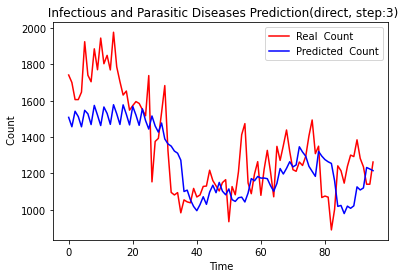

In [ ]:
plt.plot(test_labels, color = 'red', label = 'Real  Count')
plt.plot(pred, color = 'blue', label = 'Predicted  Count')
plt.title(' Infectious and Parasitic Diseases Prediction(direct, step:3)')
plt.xlabel('Time')
plt.ylabel(' Count')
plt.legend()
plt.show()

# Recursive Multi-step Forecast
#### prediction(t+1) = model(obs(t-1), obs(t-2), ..., obs(t-n))
#### prediction(t+2) = model(prediction(t+1), obs(t-1), ..., obs(t-n))

In [ ]:
# create the train, validation, and test datasets
train_tensor = torch.tensor(train_set.values, dtype=torch.float32)
val_tensor = torch.tensor(val_set.values, dtype=torch.float32)
test_tensor = torch.tensor(test_set.values, dtype=torch.float32)

# create new training, validation, and test datasets
train_data = []
for i in range(0, (len(train_tensor)-9), 3):
    train_data.append((train_tensor[i:i+7], train_tensor[i+7:i+10, 0], train_tensor[i+7:i+10, 1:]))
inputs, labels, remainings = zip(*train_data)
train_dataset = TensorDataset(torch.stack(inputs), torch.stack(labels), torch.stack(remainings))

val_data = []
for i in range(0, (len(val_tensor)-9), 3):
    val_data.append((val_tensor[i:i+7], val_tensor[i+7:i+10, 0], val_tensor[i+7:i+10, 1:]))
inputs, labels, remainings = zip(*val_data)
val_dataset = TensorDataset(torch.stack(inputs), torch.stack(labels), torch.stack(remainings))

test_data = []
for i in range(0, (len(test_tensor)-9), 3):
    test_data.append((test_tensor[i:i+7], test_tensor[i+7:i+10, 0], test_tensor[i+7:i+10, 1:]))
inputs, labels, remainings = zip(*test_data)
test_dataset = TensorDataset(torch.stack(inputs), torch.stack(labels), torch.stack(remainings))

# create the train, validation, and test dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
len(train_loader.dataset)

133

In [ ]:
# define the LSTM model for recursive multi-step forecasting
class RecursiveLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RecursiveLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, remainings):
        outputs = []
        for i in range(3):
            out, state = self.lstm(x)
            out = self.fc(out[:, -1, :])
            outputs.append(out)
            
            # Shift the input tensor one time step forward
            x = x[:, 1:, :]
            
            # Create a new time step with the same number of features as the original input
            new_time_step = x[:, -1:, :].clone()
            
            # Update the first feature (target variable) of the new time step with the predicted value
            new_time_step[:, :, 0] = out.squeeze().unsqueeze(1)
            
            # Update the remaining features of the new time step with the corresponding values from labels
            new_time_step[:, :, 1:] = remainings[:, i:i+1, :]
            
            # Concatenate the remaining time steps with the new time step
            x = torch.cat([x, new_time_step], dim=1)

        return torch.cat(outputs, dim=1)


# initialize the model and define the loss and optimizer for recursive multi-step forecasting
input_size = train_tensor.shape[1]
hidden_size = 16
num_layers = 2
model = RecursiveLSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# train the model for recursive multi-step forecasting
num_epochs = 350
best_val_loss = float('inf')
best_epoch = 0
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # train the model
    train_loss = 0.0
    model.train()
    for inputs, targets, remainings in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, remainings)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    # evaluate the model on the validation set
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets, remainings in val_loader:
            outputs = model(inputs, remainings)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)

        
    # append the training and validation loss for this epoch
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # print the training and validation loss for each epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, val_loss))
    
    
    # save
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'lstm_model.pt')

print('The epoch corresponding to the optimal validation loss is {}'.format(best_epoch))


Epoch [1/350], Train Loss: 1.0752, Val Loss: 1.3489
Epoch [2/350], Train Loss: 1.0711, Val Loss: 1.3492
Epoch [3/350], Train Loss: 1.0688, Val Loss: 1.3491
Epoch [4/350], Train Loss: 1.0667, Val Loss: 1.3488
Epoch [5/350], Train Loss: 1.0647, Val Loss: 1.3485
Epoch [6/350], Train Loss: 1.0628, Val Loss: 1.3481
Epoch [7/350], Train Loss: 1.0609, Val Loss: 1.3478
Epoch [8/350], Train Loss: 1.0589, Val Loss: 1.3474
Epoch [9/350], Train Loss: 1.0570, Val Loss: 1.3470
Epoch [10/350], Train Loss: 1.0551, Val Loss: 1.3466
Epoch [11/350], Train Loss: 1.0531, Val Loss: 1.3462
Epoch [12/350], Train Loss: 1.0511, Val Loss: 1.3457
Epoch [13/350], Train Loss: 1.0491, Val Loss: 1.3453
Epoch [14/350], Train Loss: 1.0471, Val Loss: 1.3448
Epoch [15/350], Train Loss: 1.0450, Val Loss: 1.3442
Epoch [16/350], Train Loss: 1.0429, Val Loss: 1.3436
Epoch [17/350], Train Loss: 1.0407, Val Loss: 1.3430
Epoch [18/350], Train Loss: 1.0385, Val Loss: 1.3423
Epoch [19/350], Train Loss: 1.0362, Val Loss: 1.3415
Ep

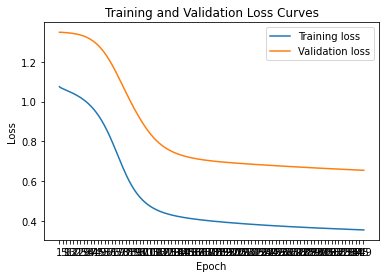

In [ ]:
# plot the training and validation loss curves
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_losses)+1, 4))
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [ ]:
# evaluate the model on the test set
model = RecursiveLSTMModel(input_size, hidden_size, num_layers)
model.load_state_dict(torch.load('lstm_model.pt'))
model.eval()
test_loss = 0.0
outputs_list = []
targets_list = []
with torch.no_grad():
    # a = 0
    for inputs, targets, remainings in test_loader:
        outputs = model(inputs, remainings)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        for i in range(len(outputs)):
            for j in range(len(outputs[i])):
              outputs_list.append(outputs[i][j].squeeze())
              targets_list.append(targets[i][j])
              loss = criterion(outputs[i][j].squeeze(), targets[i][j])
              # print('Output {}: Loss: {:.4f}'.format(a, loss))
              # a += 1
    test_loss /= len(test_loader.dataset)
outputs_arr = np.array(outputs_list)
outputs_arr = outputs_arr.reshape(-1,1)
targets_arr = np.array(targets_list)
targets_arr = targets_arr.reshape(-1,1)
print('Test Loss: {:.4f}'.format(test_loss)) 

Test Loss: 0.8278


In [ ]:
outputs_arr_copy = np.repeat(outputs_arr,5, axis=-1)
outputs_arr_copy.shape

(129, 5)

In [ ]:
pred = scaler.inverse_transform(np.reshape(outputs_arr_copy,(len(outputs_arr),5)))[:,0]
pred

array([1535.5835 , 1528.5337 , 1521.4761 , 1531.6527 , 1531.209  ,
       1533.2999 , 1546.8942 , 1543.8983 , 1537.1506 , 1549.3799 ,
       1551.4993 , 1549.3032 , 1560.29   , 1555.8909 , 1552.7946 ,
       1563.8586 , 1558.5205 , 1552.2092 , 1551.8502 , 1548.2401 ,
       1538.1508 , 1535.7131 , 1522.8289 , 1514.6727 , 1517.5302 ,
       1510.1287 , 1492.1813 , 1478.1729 , 1463.0801 , 1452.4854 ,
       1399.3391 , 1368.1489 , 1355.5112 , 1295.5896 , 1263.5966 ,
       1201.4392 , 1103.862  , 1067.889  , 1022.23694, 1006.75964,
       1012.94196, 1010.90607, 1032.2784 , 1057.2426 , 1059.9109 ,
       1093.8184 , 1080.0747 , 1077.324  , 1082.5953 , 1060.6885 ,
       1043.605  , 1040.3013 , 1021.7439 , 1013.734  , 1027.808  ,
       1022.62146, 1017.3808 , 1083.4751 , 1107.9313 , 1108.6099 ,
       1138.5385 , 1119.992  , 1074.8334 , 1068.9967 , 1106.1747 ,
       1119.1882 , 1173.6101 , 1208.0254 , 1226.3896 , 1299.4512 ,
       1314.0411 , 1359.2452 , 1383.7245 , 1383.1089 , 1384.08

In [ ]:
targets_arr_copy = np.repeat(targets_arr,5, axis=-1)
test_labels = scaler.inverse_transform(np.reshape(targets_arr_copy,(len(targets_arr),5)))[:,0]
test_labels

array([1741., 1700., 1606., 1606., 1647., 1924., 1740., 1704., 1885.,
       1770., 1944., 1803., 1849., 1769., 1976., 1786., 1705., 1631.,
       1653., 1548., 1573., 1595., 1585., 1551., 1517., 1738., 1154.,
       1376., 1393., 1535., 1683., 1324., 1096., 1082., 1095.,  984.,
       1055., 1044., 1039., 1118., 1071., 1082., 1129., 1131., 1218.,
       1161., 1132., 1104., 1150., 1166.,  935., 1128., 1083., 1210.,
       1413., 1474., 1148., 1089., 1197., 1265., 1080., 1222., 1327.,
       1209., 1072., 1349., 1272., 1353., 1439., 1321., 1221., 1212.,
       1263., 1244., 1295., 1407., 1494., 1309., 1350., 1068., 1076.,
       1070.,  890., 1003., 1242., 1215., 1147., 1239., 1301., 1293.,
       1385., 1283., 1237., 1141., 1141., 1263., 1191., 1231., 1087.,
       1236., 1248., 1359., 1297., 1090., 1355., 1345., 1442., 1306.,
       1420., 1549., 1373., 1411., 1310., 1269., 1347., 1475., 1513.,
       1565., 1425., 1464., 1573., 1478., 1566., 1527., 1539., 1711.,
       1389., 1621.,

MAPE: 10.32%


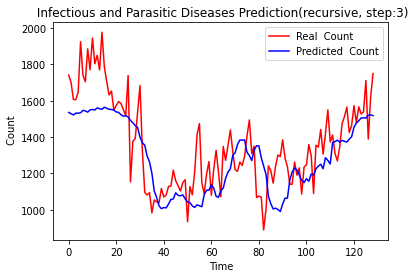

In [ ]:
def mape(actual, predicted):
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

mape_value = mape(test_labels, pred)
print("MAPE: {:.2f}%".format(mape_value))

plt.plot(test_labels, color = 'red', label = 'Real  Count')
plt.plot(pred, color = 'blue', label = 'Predicted  Count')
plt.title(' Infectious and Parasitic Diseases Prediction(recursive, step:3)')
plt.xlabel('Time')
plt.ylabel(' Count')
plt.legend()
plt.show()

In [ ]:
print(inputs)

tensor([[[ 0.6041, -0.4513, -0.5508,  1.1475,  0.9419],
         [ 1.0889, -0.3044, -0.2561, -0.6934, -0.2901],
         [ 0.5514, -0.6148,  0.0401,  0.8761,  0.4828],
         [ 0.3090, -0.7450, -0.6370,  1.5423,  0.7748],
         [-0.1969, -1.1144,  0.6251,  0.0161, -0.3642],
         [-0.1969, -0.9463,  0.1074,  0.7957, -0.5718],
         [ 0.4460, -0.6072,  0.0698,  1.1299, -0.4942]],

        [[ 0.3090, -0.7450, -0.6370,  1.5423,  0.7748],
         [-0.1969, -1.1144,  0.6251,  0.0161, -0.3642],
         [-0.1969, -0.9463,  0.1074,  0.7957, -0.5718],
         [ 0.4460, -0.6072,  0.0698,  1.1299, -0.4942],
         [ 0.0666, -0.7843, -1.0001,  2.6422,  0.3786],
         [ 0.2774, -0.6996,  0.6433,  0.7812, -0.6959],
         [-0.4814, -0.9463,  0.2360,  0.6606, -0.4601]],

        [[ 0.4460, -0.6072,  0.0698,  1.1299, -0.4942],
         [ 0.0666, -0.7843, -1.0001,  2.6422,  0.3786],
         [ 0.2774, -0.6996,  0.6433,  0.7812, -0.6959],
         [-0.4814, -0.9463,  0.2360,  0.6606

In [ ]:
print(targets)

tensor([[ 0.0666,  0.2774, -0.4814],
        [ 0.3038,  0.3670,  0.9519],
        [ 0.6252, -0.4656,  0.9308],
        [ 0.8781,  1.3893,  0.6726],
        [ 1.2733,  1.9531,  1.0257],
        [ 1.2259,  0.6937,  0.4776],
        [ 0.8887,  1.5632,  1.7634],
        [ 2.0374,  1.2997,  1.5052],
        [ 2.0796,  1.5790,  2.0427],
        [ 1.8372,  1.9004,  2.8068],
        [ 1.1100,  2.3325,  3.0070]])


In [ ]:
print(remainings)

tensor([[[-0.7843, -1.0001,  2.6422,  0.3786],
         [-0.6996,  0.6433,  0.7812, -0.6959],
         [-0.9463,  0.2360,  0.6606, -0.4601]],

        [[-0.5618,  1.0581,  0.2154, -0.8356],
         [-0.6011, -0.9248,  2.4881, -0.0859],
         [-0.6360, -0.5915,  1.7493,  0.1403]],

        [[-0.5209,  0.0370,  0.5143, -0.2018],
         [-1.2431,  0.9787, -0.9084, -0.1101],
         [-0.5148, -0.5069,  0.5585,  0.1122]],

        [[-0.2817, -0.8801,  1.0713,  0.5900],
         [-0.3226, -0.2801,  1.2482,  0.6777],
         [-0.6632, -0.8851,  1.7203,  0.5276]],

        [[-0.9161, -0.7325,  0.3733,  0.2201],
         [-0.5618, -1.0152,  1.0478,  0.7110],
         [-0.8343, -1.0350,  2.0989,  1.3482]],

        [[-0.8373, -0.0722,  0.9993,  0.4750],
         [-1.2915, -0.7065,  1.0245,  0.1714],
         [-1.1583,  0.7679, -0.5467, -0.4128]],

        [[-1.0781, -0.7921,  0.4681,  0.1923],
         [-1.0039,  0.3481, -0.1337, -0.0090],
         [-1.0175, -1.1208,  2.0085,  0.1988]],


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
test_set

,Infectious and Parasitic Diseases,Respiratory Infection,Daily_Rainfall_Total_mm,Mean_Temperature_C,Mean_Wind_Speed_kmh
Epic_week,,,,,
2016_20,2.854213,0.118015,0.196785,1.400665,-0.269250
2016_21,2.632892,0.267902,0.057841,2.125467,0.140829
2016_22,1.942581,0.410219,-0.414869,0.920665,-0.644189
2016_23,1.800304,0.149809,-0.095478,1.286607,-0.390481
2016_24,1.547365,-0.063667,0.826997,0.405909,-0.116392
2016_25,2.121746,0.301210,-0.126753,0.756813,-0.356045
2016_26,2.653971,0.546480,-1.196392,2.689390,0.160507
2016_27,2.964874,0.756928,-0.545585,2.512924,0.503470
2016_28,2.748822,0.445042,0.088068,0.829904,-0.258708
